# Redis Vector Search Benchmarking with RedisVL

## A Practical Guide to Multiprocessing Performance Testing

This tutorial demonstrates how to benchmark Redis vector search performance using multiprocessing with RedisVL to bypass Python's GIL and achieve true parallelism.

### What You'll Learn
- Set up efficient Redis connections for multiprocessing
- Implement multi-process data loading with batching
- Build parallel query execution with worker processes
- Measure and analyze key performance metrics
- Understand factors affecting Redis performance

### Tutorial Structure
1. **Part 1: Setup & Configuration** - We'll define all our classes, functions, and utilities
2. **Part 2: Benchmarking Execution** - We'll run the actual performance tests and analyze results

---

## Part 1: Setup & Configuration

First, let's install dependencies and import the libraries we'll need for benchmarking.

In [1]:
# Install and import dependencies
%pip install redisvl redis numpy matplotlib pandas tqdm

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import get_context
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass
from tqdm import tqdm
from contextlib import contextmanager

# RedisVL imports
import redis
from redisvl.index import SearchIndex
from redisvl.query import VectorQuery
from redisvl.schema import IndexSchema

### Redis instance
Set up a local Redis instance to use for testing

In [3]:
!docker run -d --name redis -p 6379:6379 -v redis_data:/data --restart unless-stopped redis:8.0.0 redis-server --search-workers 6

### Configuration Class & Redis Connection

We'll define our benchmark configuration. Note that for multiprocessing, we don't use connection pooling since each process will create its own Redis client.

In [4]:
# Benchmark configuration
@dataclass
class BenchmarkConfig:
    # Redis settings
    redis_host: str = "localhost"
    redis_port: int = 6379
    redis_password: Optional[str] = None
    
    # Index settings
    index_name: str = "benchmark_index"
    vector_dim: int = 768
    distance_metric: str = "cosine"
    algorithm: str = "hnsw"  # flat or hnsw
    
    # Data settings
    data_size: int = 500000
    batch_size: int = 1000
    query_count: int = 10000
    num_results: int = 5
    
    # Multiprocessing settings
    workers: int = 10
    mp_start_method: str = "fork"

In [5]:
def create_redis_client(config: BenchmarkConfig) -> redis.Redis:
    return redis.Redis(
        host=config.redis_host,
        port=config.redis_port,
        password=config.redis_password,
    )

### Core Utility Classes

Next, we'll define our core utilities: a vector generator for creating test data and a timing context manager.

In [6]:
class VectorGenerator:
    """Generate normalized random vectors for testing"""
    def __init__(self, dimension: int, seed: int = 42):
        self.dimension = dimension
        np.random.seed(seed)
    
    def generate_vectors(self, count: int) -> np.ndarray:
        """Generate normalized random vectors"""
        vectors = np.random.randn(count, self.dimension).astype(np.float32)
        return vectors

In [7]:
@contextmanager
def timer(name: Optional[str] = None):
    """Unified context manager for timing operations
    
    Usage:
        # Auto-logging version:
        with timer("Test data generation"):
            # do work
        
        # Get elapsed time version:
        with timer() as elapsed:
            # do work
        total_time = elapsed()
        
        # Both (log + get time):
        with timer("Loading data") as elapsed:
            # do work
        throughput = ops / elapsed()
    """
    start_time = time.perf_counter()
    elapsed = lambda: time.perf_counter() - start_time
    
    try:
        yield elapsed
    finally:
        if name:
            print(f"⏱️ {name}: {elapsed():.2f}s")

### Index Management Functions

Now we'll define functions to create and manage our Redis vector search index using RedisVL schemas.

In [8]:
def create_index_schema(config: BenchmarkConfig) -> IndexSchema:
    """Create RedisVL index schema"""
    schema_dict = {
        "index": {
            "name": config.index_name,
            "prefix": f"{config.index_name}:",
            "storage_type": "hash"
        },
        "fields": [
            {
                "name": "vector",
                "type": "vector",
                "attrs": {
                    "dims": config.vector_dim,
                    "distance_metric": config.distance_metric,
                    "algorithm": config.algorithm,
                    "datatype": "float32",
                    "initial_cap": config.data_size
                }
            },
            {"name": "id", "type": "text"},
            {"name": "metadata", "type": "text"}
        ]
    }
    return IndexSchema.from_dict(schema_dict)

def setup_index(config: BenchmarkConfig, redis_client: redis.Redis) -> SearchIndex:
    """Create and return search index using provided Redis client"""
    schema = create_index_schema(config)
    search_index = SearchIndex(schema, redis_client)
    search_index.create(overwrite=True)
    print(f"✅ Created index: {config.index_name} ({config.algorithm}, {config.vector_dim}D)")
    return search_index

### Multiprocessing Worker Functions

Here we define the worker functions and initialization for multiprocessing. Each process will have its own Redis client.

In [9]:
# Global variables for multiprocessing workers
_redis_client = None
_search_index = None
_config = None

def init_worker(config_dict: dict):
    """Initialize Redis connection and search index in each worker process
    
    Each process needs its own Redis client - cannot share across processes.
    """
    global _redis_client, _search_index, _config
    
    # Reconstruct config from dict
    _config = BenchmarkConfig(**config_dict)
    
    # Create Redis client for this process (process-local)
    _redis_client = create_redis_client(_config)
    
    # Create search index with process-local client
    _search_index = SearchIndex(create_index_schema(_config), _redis_client)

### Data Loading Functions

Here we define both sequential and multiprocessing data loading functions.

In [10]:
def load_batch_worker(
    batch_data: List[Tuple[int, np.ndarray]], 
    redis_client: Optional[redis.Redis] = None, 
    config: Optional[BenchmarkConfig] = None
) -> Tuple[int, float]:
    """Load a batch of vectors using Redis pipeline (worker function)
    
    For sequential: uses passed redis_client (shared)
    For parallel: uses global _redis_client (process-local)
    """
    # Use passed parameters (sequential) or fall back to globals (multiprocessing)
    client = redis_client or _redis_client
    cfg = config or _config
    
    with timer() as elapsed:
        with client.pipeline(transaction=False) as pipe:
            for doc_id, vector in batch_data:
                pipe.hset(f"{cfg.index_name}:{doc_id}", mapping={
                    "vector": vector.tobytes(),
                    "id": f"doc_{doc_id}",
                    "metadata": f"document_{doc_id}"
                })
            pipe.execute()
    elapsed_ms = elapsed() * 1000
    return len(batch_data), elapsed_ms

# Wrapper functions for multiprocessing (needed for pickling)
def load_batch_worker_mp(batch_data: List[Tuple[int, np.ndarray]]) -> Tuple[int, float]:
    """Multiprocessing wrapper for load_batch_worker"""
    return load_batch_worker(batch_data)

In [11]:
def run_loading_benchmark(
    config: BenchmarkConfig, 
    vectors: np.ndarray, 
    method: str = "sequential",
    redis_client: Optional[redis.Redis] = None
) -> Dict[str, Any]:
    """Run loading benchmark using specified method
    
    Args:
        redis_client: For sequential execution, reuse this client
    """
    
    if method == "sequential":
        print(f"📥 Loading {len(vectors):,} vectors (sequential)...")
        
        # Create batches
        batches = []
        for i in range(0, len(vectors), config.batch_size):
            batch_vectors = vectors[i:i + config.batch_size]
            batch_data = [(i + j, batch_vectors[j]) for j in range(len(batch_vectors))]
            batches.append(batch_data)
        
        # Execute batches sequentially using shared client
        with timer() as elapsed:
            for batch_data in tqdm(batches, desc="Loading"):
                batch_size, _ = load_batch_worker(batch_data, redis_client, config)
        
        total_loaded = len(vectors)
        total_time = elapsed()
        
    elif method == "multiprocess":
        print(f"📥 Loading {len(vectors):,} vectors ({config.workers} processes)...")
        
        # Create batches for parallel processing
        batches = []
        for i in range(0, len(vectors), config.batch_size):
            batch_vectors = vectors[i:i + config.batch_size]
            batch_data = [(i + j, batch_vectors[j]) for j in range(len(batch_vectors))]
            batches.append(batch_data)
        
        ctx = get_context(config.mp_start_method)
        config_dict = config.__dict__
        
        with timer() as elapsed:
            # Each process will create its own Redis client via init_worker
            with ctx.Pool(
                processes=config.workers,
                initializer=init_worker,
                initargs=(config_dict,)
            ) as pool:
                results = list(tqdm(
                    pool.imap_unordered(load_batch_worker_mp, batches),
                    total=len(batches),
                    desc="Loading"
                ))
        
        total_time = elapsed()
        # Process results: (batch_size, latency_ms) tuples
        total_loaded = sum(batch_size for batch_size, _ in results)
    
    return {
        "total_time": total_time,
        "throughput": total_loaded / total_time,
        "total_ops": total_loaded,
        "success_rate": 100.0
    }

### Query Execution Functions

Now we'll define our query execution functions for both sequential and multiprocessing approaches.

In [12]:
def query_worker(
    query_vector: np.ndarray,
    search_index: Optional[SearchIndex] = None,
    config: Optional[BenchmarkConfig] = None
) -> Tuple[bool, float]:
    """Execute a single vector search query (worker function)
    
    For sequential: uses passed search_index (shared client)
    For parallel: uses global _search_index (process-local client)
    """
    # Use passed parameters (sequential) or fall back to globals (multiprocessing)
    index = search_index or _search_index
    cfg = config or _config
    
    try:
        with timer() as elapsed:
            query = VectorQuery(
                vector=query_vector,
                vector_field_name="vector",
                num_results=cfg.num_results,
                return_score=True
            )
            results = index.query(query)
        elapsed_ms = elapsed() * 1000
        return True, elapsed_ms
    except Exception as e:
        print(f"Query failed: {e}")
        return False, 0.0

# Wrapper functions for multiprocessing (needed for pickling)
def query_worker_mp(query_vector: np.ndarray) -> Tuple[bool, float]:
    """Multiprocessing wrapper for query_worker"""
    return query_worker(query_vector)

In [13]:
def run_query_benchmark(
    config: BenchmarkConfig, 
    query_vectors: np.ndarray,
    method: str = "sequential",
    search_index: Optional[SearchIndex] = None
) -> Dict[str, Any]:
    """Run query benchmark using specified method
    
    Args:
        search_index: For sequential execution, reuse this index (with shared client)
    """
    
    if method == "sequential":
        print(f"🔍 Executing {len(query_vectors):,} queries (sequential)...")
        latencies = []
        failed_queries = 0
        
        with timer() as elapsed:
            for query_vector in tqdm(query_vectors, desc="Querying"):
                success, latency_ms = query_worker(query_vector, search_index, config)
                if success:
                    latencies.append(latency_ms)
                else:
                    failed_queries += 1
        
        total_time = elapsed()
        
    elif method == "multiprocess":
        print(f"🔍 Executing {len(query_vectors):,} queries ({config.workers} processes)...")
        
        ctx = get_context(config.mp_start_method)
        config_dict = config.__dict__
        
        with timer() as elapsed:
            # Each process will create its own Redis client and search index via init_worker
            with ctx.Pool(
                processes=config.workers,
                initializer=init_worker,
                initargs=(config_dict,)
            ) as pool:
                results = list(tqdm(
                    pool.imap_unordered(query_worker_mp, query_vectors),
                    total=len(query_vectors),
                    desc="Querying"
                ))
        
        total_time = elapsed()
        # Process results: (success, latency_ms) tuples
        latencies = [latency for success, latency in results if success]
        failed_queries = len([r for r in results if not r[0]])
    
    if latencies:
        return {
            "total_time": total_time,
            "qps": len(latencies) / total_time,
            "avg_latency": np.mean(latencies),
            "p95_latency": np.percentile(latencies, 95),
            "p99_latency": np.percentile(latencies, 99),
            "successful_queries": len(latencies),
            "failed_queries": failed_queries,
            "success_rate": (len(latencies) / len(query_vectors)) * 100
        }
    else:
        return {"error": "No successful queries"}

---

## Part 2: Benchmarking Execution

Now that we have all our functions defined, let's run the actual benchmarks! We'll start by setting up our test environment and data.

### Initialize Environment

Let's test our Redis connection, generate test vectors, and create our search index.

In [14]:
# Initialize configuration (you can modify these values as needed)
config = BenchmarkConfig()
print(f"📊 Configuration: {config.data_size:,} vectors, {config.vector_dim}D, {config.workers} processes")

# Create Redis client
try:
    redis_client = create_redis_client(config)
    redis_client.ping()
    info = redis_client.info()
    print(f"✅ Connected to Redis {info['redis_version']}")
    print(f"   Memory: {info['used_memory_human']} used")
    
    # Clear any existing data and create fresh index using shared client
    redis_client.flushdb()
    search_index = setup_index(config, redis_client)
except Exception as e:
    print(f"❌ Redis connection failed: {e}")
    raise

📊 Configuration: 500,000 vectors, 768D, 10 processes
✅ Connected to Redis 8.0.0
   Memory: 498.52M used
✅ Created index: benchmark_index (hnsw, 768D)


Initialize vector generator and create test/query vector data based on config.

In [15]:
# Generate test data
with timer("Test data generation"):
    vector_gen = VectorGenerator(config.vector_dim)
    test_vectors = vector_gen.generate_vectors(config.data_size)
    query_vectors = vector_gen.generate_vectors(config.query_count)

print(f"📊 Generated {len(test_vectors):,} test vectors ({test_vectors.nbytes / 1024 / 1024:.1f} MB)")
print(f"🔍 Generated {len(query_vectors):,} query vectors for testing")

⏱️ Test data generation: 5.10s
📊 Generated 500,000 test vectors (1464.8 MB)
🔍 Generated 10,000 query vectors for testing


### Data Loading Benchmark

Now let's compare sequential vs multiprocessing data loading performance.

In [16]:
print("🔬 Data Loading Performance Comparison\n")

# Sequential loading benchmark
print("=== Sequential Loading ===")
with timer("Sequential loading"):
    # Pass shared Redis client to avoid creating new connections
    sequential_load_stats = run_loading_benchmark(config, test_vectors, "sequential", redis_client)
print(f"Results: {sequential_load_stats['throughput']:.1f} ops/sec")

# Reset for multi-process test (reuse same client and index)
redis_client.flushdb()
search_index = setup_index(config, redis_client)

print("\n=== Multi-process Loading ===")
with timer("Multi-process loading"):
    # Multiprocessing will create separate clients per process
    multiprocess_load_stats = run_loading_benchmark(config, test_vectors, "multiprocess")
print(f"Results: {multiprocess_load_stats['throughput']:.1f} ops/sec")

# Calculate loading performance improvement
loading_speedup = multiprocess_load_stats['throughput'] / sequential_load_stats['throughput']
loading_time_reduction = (sequential_load_stats['total_time'] - multiprocess_load_stats['total_time']) / sequential_load_stats['total_time'] * 100

print(f"\n🚀 Loading Performance:")
print(f"   {loading_speedup:.1f}x faster with {config.workers} processes")
print(f"   Time saved: {loading_time_reduction:.1f}%")

# Wait for indexing to complete
with timer("Redis indexing"):
    time.sleep(3)
    index_info = search_index.info()
print(f"✅ Index ready: {index_info.get('num_docs', 0):,} documents indexed")

🔬 Data Loading Performance Comparison

=== Sequential Loading ===
📥 Loading 500,000 vectors (sequential)...


Loading: 100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


⏱️ Sequential loading: 198.16s
Results: 2524.4 ops/sec
✅ Created index: benchmark_index (hnsw, 768D)

=== Multi-process Loading ===
📥 Loading 500,000 vectors (10 processes)...


Loading: 100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


⏱️ Multi-process loading: 199.70s
Results: 2505.2 ops/sec

🚀 Loading Performance:
   1.0x faster with 10 processes
   Time saved: -0.8%
⏱️ Redis indexing: 3.01s
✅ Index ready: 500,000 documents indexed


Even though we used multiple processes to load from the client-side, the limitation here is actually the redis server indicating we would need to shard out the db in a clustered environment (Redis Cloud or Redis Enterprise Software). With additional shards, the write throughput will improve linearly.

### Query Performance Benchmark

Now let's test query performance comparing sequential vs multiprocessing execution.

In [17]:
print("\n🔬 Query Performance Comparison")

print("\n=== Sequential Queries ===")
with timer("Sequential queries"):
    # Pass shared search index to avoid creating new connections
    sequential_query_stats = run_query_benchmark(config, query_vectors, "sequential", search_index)
if "error" not in sequential_query_stats:
    print(f"Results: {sequential_query_stats['qps']:.1f} QPS, {sequential_query_stats['avg_latency']:.2f}ms avg")

print("\n=== Multi-process Queries ===")
with timer("Multi-process queries"):
    # Multiprocessing will create separate clients per process
    multiprocess_query_stats = run_query_benchmark(config, query_vectors, "multiprocess")
if "error" not in multiprocess_query_stats:
    print(f"Results: {multiprocess_query_stats['qps']:.1f} QPS, {multiprocess_query_stats['avg_latency']:.2f}ms avg")
    
    # Calculate query performance improvement
    query_speedup = multiprocess_query_stats['qps'] / sequential_query_stats['qps']
    query_time_reduction = (sequential_query_stats['total_time'] - multiprocess_query_stats['total_time']) / sequential_query_stats['total_time'] * 100
    
    print(f"\n🚀 Query Performance:")
    print(f"   {query_speedup:.1f}x faster with {config.workers} processes")
    print(f"   Time saved: {query_time_reduction:.1f}%")


🔬 Query Performance Comparison

=== Sequential Queries ===
🔍 Executing 10,000 queries (sequential)...


Querying: 100%|██████████| 10000/10000 [00:11<00:00, 883.63it/s]

⏱️ Sequential queries: 11.33s
Results: 883.4 QPS, 1.11ms avg

=== Multi-process Queries ===
🔍 Executing 10,000 queries (10 processes)...



Querying: 100%|██████████| 10000/10000 [00:01<00:00, 9130.64it/s]

⏱️ Multi-process queries: 1.16s
Results: 8663.6 QPS, 1.05ms avg

🚀 Query Performance:
   9.8x faster with 10 processes
   Time saved: 89.8%


The near 10x improvement in search throughput as we scale client-side processes indicates we haven't fully saturated the Redis server! Additional throughput can be achieved on Redis Cloud / Redis Enterprise Software with additional QPF (search threads) and sharding as the data volume grows. The best solution is a healthy balance of horozontal and vertical scale.

[Read more about benchmarking techniques and Redis query engine architecture.](https://redis.io/blog/benchmarking-results-for-vector-databases/)

### Performance Analysis & Visualization

Let's analyze our results and create visualizations to better understand the performance improvements.

In [18]:
# Performance Summary
if "error" not in sequential_query_stats and "error" not in multiprocess_query_stats:
    print(f"\n📊 Summary:")
    print(f"   Loading: {sequential_load_stats['throughput']:.0f} → {multiprocess_load_stats['throughput']:.0f} ops/sec ({loading_speedup:.1f}x)")
    print(f"   Queries: {sequential_query_stats['qps']:.0f} → {multiprocess_query_stats['qps']:.0f} QPS ({query_speedup:.1f}x)")
    print(f"   Total time: {sequential_load_stats['total_time'] + sequential_query_stats['total_time']:.1f}s → {multiprocess_load_stats['total_time'] + multiprocess_query_stats['total_time']:.1f}s")
    print(f"   Peak QPS: {multiprocess_query_stats['qps']:.0f} queries/second")


📊 Summary:
   Loading: 2524 → 2505 ops/sec (1.0x)
   Queries: 883 → 8664 QPS (9.8x)
   Total time: 209.4s → 200.7s
   Peak QPS: 8664 queries/second


In [19]:
# Create comprehensive performance comparison
perf_data = {
    'Operation': ['Data Loading', 'Data Loading', 'Vector Queries', 'Vector Queries'],
    'Method': ['Sequential', 'Multi-process', 'Sequential', 'Multi-process'],
    'Throughput': [sequential_load_stats['throughput'], multiprocess_load_stats['throughput'], 
                   sequential_query_stats['qps'], multiprocess_query_stats['qps']],
    'Avg_Latency_ms': [0, 0,  # Loading doesn't track individual latencies
                       sequential_query_stats['avg_latency'], multiprocess_query_stats['avg_latency']],
    'P95_Latency_ms': [0, 0,  # Loading doesn't track individual latencies
                       sequential_query_stats['p95_latency'], multiprocess_query_stats['p95_latency']]
}

df = pd.DataFrame(perf_data)
print("📊 Performance Summary:")
print(df.to_string(index=False))

📊 Performance Summary:
     Operation        Method  Throughput  Avg_Latency_ms  P95_Latency_ms
  Data Loading    Sequential 2524.440444        0.000000        0.000000
  Data Loading Multi-process 2505.225020        0.000000        0.000000
Vector Queries    Sequential  883.366387        1.107922        1.701246
Vector Queries Multi-process 8663.586546        1.048395        1.746423


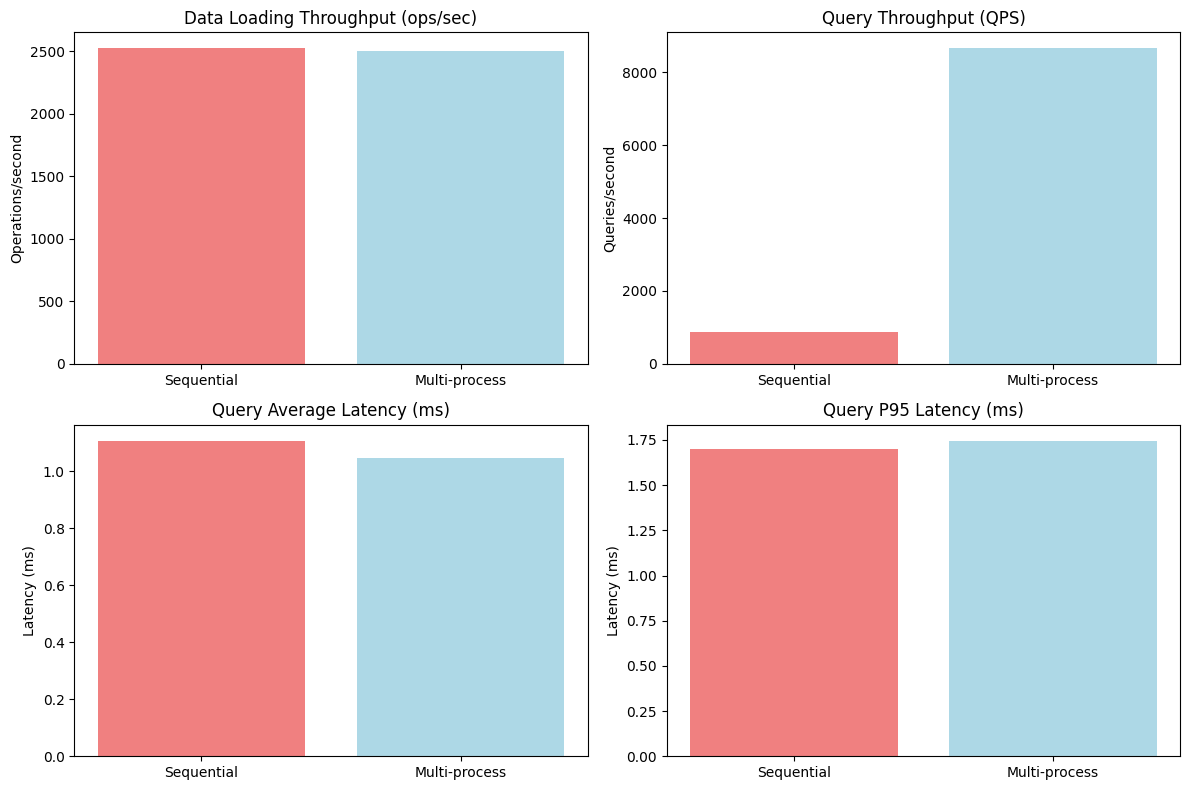


⚡ Overall Benchmark Results:
   Total time (sequential): 209.38s
   Total time (multi-process): 200.74s
   Overall speedup: 1.0x faster with multiprocessing
   Data processed: 500,000 vectors loaded, 10,000 queries executed
   Peak QPS achieved: 8664 queries/second


In [20]:
# Create performance visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Throughput comparisons
loading_throughput = df[df['Operation'] == 'Data Loading']['Throughput']
query_throughput = df[df['Operation'] == 'Vector Queries']['Throughput']

ax1.bar(['Sequential', 'Multi-process'], loading_throughput, color=['lightcoral', 'lightblue'])
ax1.set_title('Data Loading Throughput (ops/sec)')
ax1.set_ylabel('Operations/second')

ax2.bar(['Sequential', 'Multi-process'], query_throughput, color=['lightcoral', 'lightblue'])
ax2.set_title('Query Throughput (QPS)')
ax2.set_ylabel('Queries/second')

# Latency comparisons (only for queries)
query_avg_latency = df[df['Operation'] == 'Vector Queries']['Avg_Latency_ms']
query_p95_latency = df[df['Operation'] == 'Vector Queries']['P95_Latency_ms']

ax3.bar(['Sequential', 'Multi-process'], query_avg_latency, color=['lightcoral', 'lightblue'])
ax3.set_title('Query Average Latency (ms)')
ax3.set_ylabel('Latency (ms)')

ax4.bar(['Sequential', 'Multi-process'], query_p95_latency, color=['lightcoral', 'lightblue'])
ax4.set_title('Query P95 Latency (ms)')
ax4.set_ylabel('Latency (ms)')

plt.tight_layout()
plt.show()

# Calculate overall performance gains
total_sequential_time = sequential_load_stats['total_time'] + sequential_query_stats['total_time']
total_multiprocess_time = multiprocess_load_stats['total_time'] + multiprocess_query_stats['total_time']
overall_speedup = total_sequential_time / total_multiprocess_time

print(f"\n⚡ Overall Benchmark Results:")
print(f"   Total time (sequential): {total_sequential_time:.2f}s")
print(f"   Total time (multi-process): {total_multiprocess_time:.2f}s")
print(f"   Overall speedup: {overall_speedup:.1f}x faster with multiprocessing")
print(f"   Data processed: {config.data_size:,} vectors loaded, {config.query_count:,} queries executed")
print(f"   Peak QPS achieved: {multiprocess_query_stats['qps']:.0f} queries/second")

## 🚀 Quick Summary & Best Practices

**What did we learn?**
- 🧵 Multi-process loading bypasses Python's GIL for true parallelism.
- Query speedups depend on your Redis server's CPU & network.
- Each process gets its own Redis connection for safe parallel access.

**Metrics to watch:**
- **QPS** (Queries/sec): Main throughput stat
- **P95/P99 Latency**: Key for user experience
- **Success Rate**: Should stay >99%
- **Memory Usage**: Keep an eye on Redis RAM

**Performance factors:**
- More CPU cores = more workers = more speed (up to a point)
- Network can bottleneck with big vectors
- Redis needs enough RAM for all your data
- Persistence (AOF/RDB) can slow down writes
 
**Redis options:**
- OSS: Free, single-threaded, good for dev/test
- Enterprise/Cloud: Multi-threaded, clustering, auto-scaling 🚦
 
**Top tips:**
1. Match worker count to CPU cores, then tune
2. Batch ops for speed, but watch memory on client-side
3. Pick the right index for the use case: FLAT (exact), HNSW (fast/approx)
4. Higher vector dims = more RAM, slower queries
5. Be aware of networking bottlenecks and serialization overhead

**Next steps:**
- Benchmark with your real data & queries
- Benchmark in a production / cloud environment using VPC peering
- Test concurrency that matches your app
- Monitor memory, CPU, and QPS
- Plan for growth 📈

**More info:**
- [RedisVL Docs](https://docs.redisvl.com)
- [Redis Optimization](https://redis.io/docs/operate/oss_and_stack/management/optimization/)
- [Benchmarking Blog](https://redis.io/blog/benchmarking-results-for-vector-databases/)

---

🎉 **Congrats!** You're ready to benchmark and tune Redis query engine with RedisVL. Use these tips to get the best performance for your app!